[intro and member names etc]

# Final/base HOG and SVM

Notes:     # c value and regularisation

## Setup

In [4]:
# Import required libraries

# I/O and file management
import os
import shutil
import joblib

# Numerical operations and data handling
import numpy as np
import pandas as pd

# For visualisation
from matplotlib import pyplot as plt

# Image processing and feature extraction
from PIL import Image
from skimage import color, io
from difflib import SequenceMatcher
import random
from collections import Counter
from skimage.feature import hog

# Custom hog function
import custom_hog_methods
import importlib
importlib.reload(custom_hog_methods)

# Model training and evaluation
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Defining image dimensions for HOG
IMG_WIDTH = 64
IMG_HEIGHT = 128

RAW_HUMAN_DIR = "data/raw/human"
RAW_NONHUMAN_DIR = "data/raw/nonhuman_cleaned" # Cleaned nonhuman images
# RAW_NONHUMAN_DIR = "data/raw/nonhuman"

PROCESSED_HUMAN_DIR = "data/processed/human"
PROCESSED_NONHUMAN_DIR = "data/processed/nonhuman"

IMAGE_EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp")

In [12]:
# Set the seed for reproducibility
random.seed(42)
np.random.seed(42)

In [13]:
processed_dir = os.path.join('data', 'processed')

# Delete the 'processed' folder if it exists
if os.path.exists(processed_dir):
    shutil.rmtree(processed_dir)
    print(f"Deleted folder: {processed_dir}")
else:
    print(f"No folder to delete at: {processed_dir}")

Deleted folder: data/processed


## Data processing

In [14]:
# Checking it can read the data
# from subprocess import check_output
# print(check_output(["ls", "data/raw/human"]).decode("utf8"))

In [15]:
# Directories
input_folder = "data/raw/human"
output_folder = "data/processed/human_deduplicated"
os.makedirs(output_folder, exist_ok=True)

def is_new_person(prev, curr, threshold=0.4):
    # Similarity ratio between the filenames (0 to 1)
    similarity = SequenceMatcher(None, prev, curr).ratio()
    
    # Change in length (as % of longer filename)
    len_change = abs(len(prev) - len(curr)) / max(len(prev), len(curr))

    # Consider a new person if similarity is low or length difference is high
    return similarity < (1 - threshold) or len_change > 0.4

filenames = sorted([
    f for f in os.listdir(input_folder)
    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
])

# Group based on filename change
grouped = []
current_group = [filenames[0]]

for i in range(1, len(filenames)):
    if is_new_person(filenames[i - 1], filenames[i]):
        grouped.append(current_group)
        current_group = [filenames[i]]
    else:
        current_group.append(filenames[i])

grouped.append(current_group)  # Add the last group

# Print out group sizes
for idx, group in enumerate(grouped):
    print(f"Person {idx:03d} ({len(group)} images): {group}")

# Copy one image per group
for idx, group in enumerate(grouped):
    representative = group[0]
    src = os.path.join(input_folder, representative)
    dst = os.path.join(output_folder, representative)
    shutil.copy2(src, dst)

print(f"Deduplicated {len(filenames)} → {len(grouped)} images.")


Person 000 (19 images): ['00001_male_back.jpg', '00002_male_back.jpg', '00003_male_back.jpg', '00004_male_back.jpg', '00005_male_back.jpg', '00006_female_back.jpg', '00007_male_fore.jpg', '00008_male_fore.jpg', '00009_male_back.jpg', '00010_female_fore.jpg', '00011_male_fore.jpg', '00012_female_fore.jpg', '00013_male_back.jpg', '00014_female_fore.jpg', '00015_female_fore.jpg', '00016_male_fore.jpg', '00017_female_fore.jpg', '00018_male_fore.jpg', '00019_male_fore.jpg']
Person 001 (10 images): ['0001_001.jpg', '0001_002.jpg', '0001_003.jpg', '0001_004.jpg', '0001_005.jpg', '0001_006.jpg', '0001_007.jpg', '0001_008.jpg', '0001_009.jpg', '0001_010.jpg']
Person 002 (2 images): ['0001_1_25004_107_32_106_221.jpeg', '0001_2_25023_116_134_128_330.jpeg']
Person 003 (3 images): ['0001_a.png', '0001_b.png', '0002.png']
Person 004 (10 images): ['00020_female_fore.jpg', '00021_male_fore.jpg', '00022_male_fore.jpg', '00023_female_back.jpg', '00024_female_fore.jpg', '00025_female_fore.jpg', '00026_fe

### Resizing and centre cropping human image examples

`resize_and_center_crop` starts with ~18000 images and ends with ~12000 images.

`resize_with_padding` starts with ~18000 images and does not discard any images.

[*update this]


In [16]:
# input_folder = RAW_HUMAN_DIR
input_folder = "data/processed/human_deduplicated"
output_folder = "data/processed/human_resized"
os.makedirs(output_folder, exist_ok=True)

human_records = []

def resize_with_padding(img, target_width=IMG_WIDTH, target_height=IMG_HEIGHT, fill_color=(0, 0, 0)):
    img_ratio = img.width / img.height
    target_ratio = target_width / target_height

    # Resize while keeping aspect ratio (fit inside target box)
    if img_ratio > target_ratio:
        # Image is wider than target — resize based on width
        new_width = target_width
        new_height = int(target_width / img_ratio)
    else:
        # Image is taller or narrower than target — resize based on height
        new_height = target_height
        new_width = int(target_height * img_ratio)

    img_resized = img.resize((new_width, new_height), Image.LANCZOS)

    # Create new image and paste the resized on center
    new_img = Image.new("RGB", (target_width, target_height), fill_color)
    left = (target_width - new_width) // 2
    top = (target_height - new_height) // 2
    new_img.paste(img_resized, (left, top))

    return new_img

def resize_and_center_crop(img, target_width=IMG_WIDTH, target_height=IMG_HEIGHT):
    # Resize while keeping aspect ratio, but ensure the image is at least target size in both dimensions
    img_ratio = img.width / img.height
    target_ratio = target_width / target_height

    if img_ratio > target_ratio:
        # Image is wider than target — resize based on height
        new_height = target_height
        new_width = int(target_height * img_ratio)
    else:
        # Image is taller or narrower than target — resize based on width
        new_width = target_width
        new_height = int(target_width / img_ratio)

    img_resized = img.resize((new_width, new_height), Image.LANCZOS)

    # Center crop to target size
    left = (img_resized.width - target_width) // 2
    top = (img_resized.height - target_height) // 2
    right = left + target_width
    bottom = top + target_height

    return img_resized.crop((left, top, right, bottom))

for filename in os.listdir(input_folder):
    if filename.lower().endswith((IMAGE_EXTENSIONS)):
        path = os.path.join(input_folder, filename)
        img = Image.open(path).convert("RGB")
        cropped = resize_with_padding(img)
        cropped.save(os.path.join(output_folder, filename))

        human_records.append({
            "crop_filename": filename,
            "original_filename": filename,  # assuming all unique
            "crop_image": cropped
        })

### Downscaling and obtaining non-overlapping crops of nonhuman images

Starts with 1218 nonhuman images and ends with ~13000 unique nonhuman images.

In [17]:
input_folder = RAW_NONHUMAN_DIR
output_folder = PROCESSED_NONHUMAN_DIR
SAMPLE_SIZE = len(human_records) # Set to be size of human dataset
os.makedirs(output_folder, exist_ok=True)

crop_records = [] # Stores the origin image
crop_id = 0  # Unique filename ID
scale_factor = 11 / 20  # Downsize images before cropping

for fname in os.listdir(input_folder):
    # if fname.lower().endswith((IMAGE_EXTENSIONS)) and crop_id < 3561:
    if fname.lower().endswith((IMAGE_EXTENSIONS)):
        path = os.path.join(input_folder, fname)
        img = Image.open(path).convert("RGB")

        # Resize image to */* of original size
        new_width = int(img.width * scale_factor)
        new_height = int(img.height * scale_factor)
        img_resized = img.resize((new_width, new_height), Image.LANCZOS)

        # Calculate number of non-overlapping crops that fit
        num_x = new_width // IMG_WIDTH
        num_y = new_height // IMG_HEIGHT

        for y in range(num_y):
            for x in range(num_x):
                left = x * IMG_WIDTH
                top = y * IMG_HEIGHT
                right = left + IMG_WIDTH
                bottom = top + IMG_HEIGHT

                crop = img_resized.crop((left, top, right, bottom))
                crop_filename = f"nonhuman_{crop_id}.jpg"

                crop_records.append({
                    "crop_id": crop_id,
                    "crop_filename": crop_filename,
                    "original_filename": fname,
                    "crop_image": crop
                })

                crop_id += 1

print(f"Generated {len(crop_records)} crops from raw images.")

# Randomly select a subset
selected_records = random.sample(crop_records, SAMPLE_SIZE)

# Save the selected crops and record metadata
nonhuman_records = []
for record in selected_records:
    out_path = os.path.join(output_folder, record["crop_filename"])
    record["crop_image"].save(out_path)
    nonhuman_records.append({
        "crop_filename": record["crop_filename"],
        "original_filename": record["original_filename"],
        "crop_image": record["crop_image"]
    })

print(f"Subsampled and saved {SAMPLE_SIZE} crops to {output_folder}")

Generated 4314 crops from raw images.
Subsampled and saved 3562 crops to data/processed/nonhuman


## HOG and SVM training and evaluation

In [23]:
# from ablation_hog import custom_hog

# Best parameters for HOG
ORIENTATIONS = 18
PIXELS_PER_CELL = (16, 16)
CELLS_PER_BLOCK = (2, 2)
BLOCK_NORM = 'l1'
FEATURE_VECTOR = True

# Parameters for custom HOG only
GRADIENT = 'scharr'
GAMMA=1.0
GAUSSIAN_SIGMA=0.0

In [19]:
image_size = (IMG_WIDTH, IMG_HEIGHT)

# def extract_hog_features(img_path, orientations, pixels_per_cell, block_norm, feature_vector,
#                         gradient, gamma, gaussian_sigma):
#     img = Image.open(img_path).convert("L")
#     img_np = np.array(img)
    
#     hog_features = custom_hog(img_np, orientations=orientations, pixels_per_cell=pixels_per_cell,
#                             block_norm=block_norm, transform_sqrt=True,
#                             feature_vector=feature_vector, unsigned=True, gradient=gradient,
#                             gamma=gamma, gaussian_sigma=gaussian_sigma)

#     return hog_features

def extract_hog(human_records, nonhuman_records,
                orientations, pixels_per_cell, cells_per_block,
                block_norm, feature_vector, gradient, gamma,
                gaussian_sigma, transform_sqrt):
    from cst import custom_hog  # Import your custom HOG

    hog_data = []

    for label, records in [(1, human_records), (0, nonhuman_records)]:
        for record in records:
            img = np.array(record["crop_image"].convert("L"))

            # Always get both feature vector and visualization
            hog_feature, hog_image = custom_hog(
                img,
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                block_norm=block_norm,
                transform_sqrt=transform_sqrt,
                feature_vector=feature_vector,
                unsigned=True,
                gradient=gradient,
                gamma=gamma,
                gaussian_sigma=gaussian_sigma,
                visualize=True
            )

            hog_data.append({
                "features": hog_feature,
                "label": label,
                "orig_image": record["crop_image"],
                "hog_image": hog_image,
                "filename": record["crop_filename"],
                "group": record.get("original_filename", record["crop_filename"])
            })

    return hog_data


def split_by_group(data, test_size=0.2, random_state=42):
        features = [item["features"] for item in data]
        labels = [item["label"] for item in data]
        groups = [item["group"] for item in data]

        splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, test_idx = next(splitter.split(X=features, y=None, groups=groups))

        return (
            [data[i] for i in train_idx],
            [data[i] for i in test_idx]
        )

def split_data(hog_data, test_size=0.2, random_state=42):
    # Separate human and nonhuman examples
    hog_data_human = [item for item in hog_data if item["label"] == 1]
    hog_data_nonhuman = [item for item in hog_data if item["label"] == 0]

    human_train, human_test = split_by_group(hog_data_human)
    nonhuman_train, nonhuman_test = split_by_group(hog_data_nonhuman)

    train_data = human_train + nonhuman_train
    test_data = human_test + nonhuman_test

    # Shuffle combined splits
    random.shuffle(train_data)
    random.shuffle(test_data)

    # Extract final features and labels
    X_train = [item["features"] for item in train_data]
    y_train = [item["label"] for item in train_data]
    X_test = [item["features"] for item in test_data]
    y_test = [item["label"] for item in test_data]

    # Count the number of human and nonhuman images in the training and test sets
    train_counts = Counter(y_train)
    test_counts = Counter(y_test)

    return X_train, X_test, y_train, y_test

In [20]:
def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    miss_rate = 1 - recall
    # fppw = fp / len(y_true)  # False positives per window

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Miss Rate": miss_rate,
        # "FPPW": fppw
        "False Positives": fp,
        "False Positive Rate": fp / (fp + tn)
    }

def evaluate_thresholds(y_true, decision_scores, thresholds):
    results = []
    for thresh in thresholds:
        y_pred_thresh = (decision_scores >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        results.append({
            'threshold': thresh,
            'FPR': fpr,
            'FNR': fnr,
        })
    return results

def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    # Fit the model
    clf = LinearSVC(random_state=42)
    clf.fit(X_train, y_train)

    # Predict on train set
    y_train_pred = clf.predict(X_train)

    # Predict on test set
    y_test_pred = clf.predict(X_test)

    # Compute metrics
    train_metrics = compute_metrics(y_train, y_train_pred)
    test_metrics = compute_metrics(y_test, y_test_pred)

    # Get decision scores on test set
    decision_scores = clf.decision_function(X_test)

    # Define thresholds to sweep — e.g., between min and max scores
    thresholds = np.linspace(decision_scores.min(), decision_scores.max(), 100)

    # Evaluate FPR and FNR at each threshold
    threshold_results = evaluate_thresholds(y_test, decision_scores, thresholds)

    return clf, train_metrics, test_metrics, threshold_results

In [28]:
def full_pipeline(human_records, nonhuman_records,
                  orientations, pixels_per_cell, cells_per_block,
                  block_norm, feature_vector, gradient, gamma,
                  gaussian_sigma, transform_sqrt):

    hog_data = extract_hog(
        human_records,
        nonhuman_records,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm=block_norm,
        feature_vector=feature_vector,
        gradient=gradient,
        gamma=gamma,
        gaussian_sigma=gaussian_sigma,
        transform_sqrt=transform_sqrt
    )

    X_train, X_test, y_train, y_test = split_data(hog_data)
    clf, train_metrics, test_metrics, threshold_results = train_and_evaluate_model(X_train, y_train, X_test, y_test)

    return clf, train_metrics, test_metrics, threshold_results


# Run the full pipeline on the best parameters
clf, train_metrics, test_metrics, threshold_results = full_pipeline(
    human_records=human_records,
    nonhuman_records=nonhuman_records,
    orientations=ORIENTATIONS,
    pixels_per_cell=PIXELS_PER_CELL,
    cells_per_block=CELLS_PER_BLOCK,
    block_norm=BLOCK_NORM,
    feature_vector=FEATURE_VECTOR,
    gradient=GRADIENT,
    gamma=GAMMA,
    gaussian_sigma=GAUSSIAN_SIGMA,
    transform_sqrt=False
)


# Combine into a DataFrame
df = pd.DataFrame([train_metrics, test_metrics], index=["Train Set", "Test Set"])

# Display nicely
print("\n Evaluation Metrics:")
display(df.round(4))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



 Evaluation Metrics:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,0.9933,0.9947,0.9919,0.9933,0.0081,15,0.0053
Test Set,0.9709,0.9653,0.9762,0.9707,0.0238,25,0.0342


In [ ]:
joblib.dump(clf, '..//svm_model_roberts.pkl')

# Ablation studies

## Additional Study: Effect of different gradients on miss rate and false positives


In [39]:
gradients = ["central_diff", "sobel", "prewitt", "scharr", "roberts", "dog"]
gradient_metrics = []
gradient_threshold_results = []

for gradient in gradients:
    clf, train_metrics, test_metrics, threshold_results = full_pipeline(
        human_records=human_records,
        nonhuman_records=nonhuman_records,
        orientations=9,                  # Fixed value (e.g., Dalal-Triggs default)
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="l1",              # will try: l1 with sqrt
        feature_vector=True,
        gradient=gradient,               # <- Looping over this
        gamma=1.0,                       # Optional — leave at 1.0 or tune if needed
        gaussian_sigma=0.0,             # Optional
        transform_sqrt=True            # Optional
    )

    df = pd.DataFrame([train_metrics, test_metrics], index=["Train Set", "Test Set"])

    print(f"\nEvaluation Metrics using gradient: {gradient}")
    display(df.round(4))

    gradient_metrics.append((train_metrics, test_metrics))
    gradient_threshold_results.append(threshold_results)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Evaluation Metrics using gradient: central_diff


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,0.9993,0.9996,0.9989,0.9993,0.0011,1,0.0004
Test Set,0.9771,0.9709,0.9832,0.9770,0.0168,21,0.0287


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Evaluation Metrics using gradient: sobel


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,1.0000,1.0000,1.0000,1.0000,0.0000,0,0.0000
Test Set,0.9744,0.9721,0.9762,0.9741,0.0238,20,0.0274


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Evaluation Metrics using gradient: prewitt


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,0.9995,1.0000,0.9989,0.9995,0.0011,0,0.0000
Test Set,0.9758,0.9775,0.9734,0.9754,0.0266,16,0.0219


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Evaluation Metrics using gradient: scharr


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,0.9998,1.0000,0.9996,0.9998,0.0004,0,0.0000
Test Set,0.9792,0.9776,0.9804,0.9790,0.0196,16,0.0219


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Evaluation Metrics using gradient: roberts


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,0.9993,0.9996,0.9989,0.9993,0.0011,1,0.0004
Test Set,0.9744,0.9681,0.9804,0.9742,0.0196,23,0.0315


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Evaluation Metrics using gradient: dog


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,0.9991,1.0000,0.9982,0.9991,0.0018,0,0.0000
Test Set,0.9730,0.9681,0.9776,0.9728,0.0224,23,0.0315


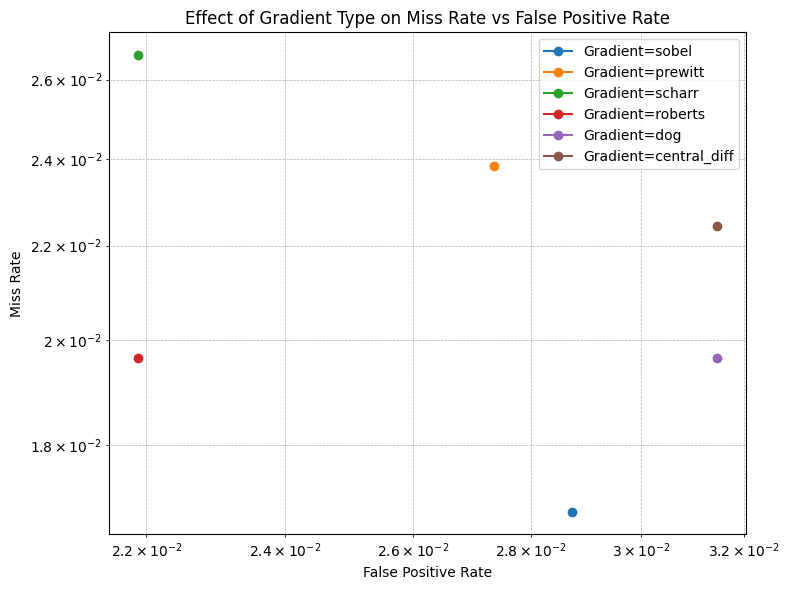

In [40]:
gradient_test_miss_rates = [test["Miss Rate"] for _, test in gradient_metrics]
gradient_test_fpr = [test["False Positive Rate"] for _, test in gradient_metrics]

plt.figure(figsize=(8, 6))

for i, gradient in enumerate(["sobel", "prewitt", "scharr", "roberts", "dog", "central_diff"]):
    fp = gradient_test_fpr[i]
    mr = gradient_test_miss_rates[i]
    plt.plot(fp, mr, marker='o', label=f'Gradient={gradient}')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("False Positive Rate")
plt.ylabel("Miss Rate")
plt.title("Effect of Gradient Type on Miss Rate vs False Positive Rate")
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Visualisation of HOG and other debugging (might be useful later)

In [ ]:
from skimage import data, exposure

def extract_hog_features(img_path):
    img = Image.open(img_path).convert("L").resize(image_size)
    img_np = np.array(img)
    hog_features, hog_image = hog(
        img_np,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        feature_vector=True,
        visualize=True,
        # channel_axis=-1,
    )
    return hog_features, hog_image

print(labels[-1])
hog_features, hog_image = extract_hog_features('data/processed/human/0_8.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

print(hog_features)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [ ]:
# Load and convert image to grayscale
image = io.imread("data/processed/human/0_8.jpg")  # replace with your path
gray_image = color.rgb2gray(image)

# Compute HOG features and visualization
features, hog_image = hog(
    gray_image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    block_norm='L2-Hys'
)

# Plot original and HOG gradient image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap="gray")
plt.title("Original Grayscale Image")

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap="gray")
plt.title("HOG Gradient Visualization")

plt.tight_layout()
plt.show()

# Visualisation

In [ ]:
sample_count = 10  # Number of triplets to sample
triplets_per_row = 2
image_size = (64, 128)
random_seed = 42

# Set random seed
random.seed(random_seed)

# Get sorted list of image paths
image_paths = sorted([
    os.path.join(RAW_HUMAN_DIR, fname)
    for fname in os.listdir(RAW_HUMAN_DIR)
    if fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp"))
])

# Ensure enough images
if len(image_paths) < 3:
    raise ValueError("Not enough images to sample neighbors")

# Sample safe central indices
central_indices = random.sample(range(1, len(image_paths) - 1), sample_count)
triplet_indices = [[i - 1, i, i + 1] for i in central_indices]

# Layout calculations
triplet_width = 3
cols = triplets_per_row * (triplet_width + 1) - 1  # +1 for spacing
rows = (sample_count + triplets_per_row - 1) // triplets_per_row

fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 3))
fig.suptitle("Random sets of consecutive images from raw human dataset", fontsize=16)

# Ensure axes is always 2D
if rows == 1:
    axes = [axes]

# Plot triplets with spacing
for i, triplet in enumerate(triplet_indices):
    row = i // triplets_per_row
    group = i % triplets_per_row
    col_start = group * (triplet_width + 1)

    for j, idx in enumerate(triplet):
        ax = axes[row][col_start + j]
        img = Image.open(image_paths[idx]).convert("RGB").resize(image_size)
        ax.imshow(img)
        ax.set_title(os.path.basename(image_paths[idx]), fontsize=6)
        ax.axis("off")

# Hide unused axes (extra columns for spacing)
for r in range(rows):
    for c in range(cols):
        if (c % (triplet_width + 1)) == triplet_width:  # spacing column
            axes[r][c].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Parameters
RAW_OTHER_DIR = "data/raw/nonhuman"
images_per_row = 4
rows = 5
random_seed = 50

# Set seed for reproducibility
random.seed(random_seed)

# Load and sort all image paths
image_paths = sorted([
    os.path.join(RAW_OTHER_DIR, fname)
    for fname in os.listdir(RAW_OTHER_DIR)
    if fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp"))
])

# Make sure we have enough images
if len(image_paths) < images_per_row:
    raise ValueError("Not enough images to display even one row.")

# Pick random start indices for each row
max_start = len(image_paths) - images_per_row
start_indices = [random.randint(0, max_start) for _ in range(rows)]

# Create plot
fig, axes = plt.subplots(rows, images_per_row, figsize=(images_per_row * 3, rows * 3))
fig.suptitle("Random sets of consecutive images from raw non-human dataset (one set per row)", fontsize=16)

# Ensure axes is 2D
if rows == 1:
    axes = [axes]

# Plot each row
for row_idx, start_idx in enumerate(start_indices):
    for col in range(images_per_row):
        img_idx = start_idx + col
        img_path = image_paths[img_idx]
        img = Image.open(img_path).convert("RGB")
        ax = axes[row_idx][col]
        ax.imshow(img)
        ax.set_title(os.path.basename(img_path), fontsize=7)
        ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
sample_count = 10  # Number of triplets to sample
triplets_per_row = 2
image_size = (64, 128)
random_seed = 42

DIRECTORY = "data/processed/human_resized"

# Set random seed
random.seed(random_seed)

# Get sorted list of image paths
image_paths = sorted([
    os.path.join(DIRECTORY, fname)
    for fname in os.listdir(DIRECTORY)
    if fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp"))
])

# Ensure enough images
if len(image_paths) < 3:
    raise ValueError("Not enough images to sample neighbors")

# Sample safe central indices
central_indices = random.sample(range(1, len(image_paths) - 1), sample_count)
triplet_indices = [[i - 1, i, i + 1] for i in central_indices]

# Layout calculations
triplet_width = 3
cols = triplets_per_row * (triplet_width + 1) - 1  # +1 for spacing
rows = (sample_count + triplets_per_row - 1) // triplets_per_row

fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 3))
fig.suptitle("Random sets of consecutive images from processed human dataset", fontsize=16)

# Ensure axes is always 2D
if rows == 1:
    axes = [axes]

# Plot triplets with spacing
for i, triplet in enumerate(triplet_indices):
    row = i // triplets_per_row
    group = i % triplets_per_row
    col_start = group * (triplet_width + 1)

    for j, idx in enumerate(triplet):
        ax = axes[row][col_start + j]
        img = Image.open(image_paths[idx]).convert("RGB").resize(image_size)
        ax.imshow(img)
        ax.set_title(os.path.basename(image_paths[idx]), fontsize=6)
        ax.axis("off")

# Hide unused axes (extra columns for spacing)
for r in range(rows):
    for c in range(cols):
        if (c % (triplet_width + 1)) == triplet_width:  # spacing column
            axes[r][c].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Parameters
RAW_OTHER_DIR = "data/processed/nonhuman"
images_per_row = 4
rows = 5
random_seed = 44

# Set seed for reproducibility
random.seed(random_seed)

# Load and sort all image paths
image_paths = sorted([
    os.path.join(RAW_OTHER_DIR, fname)
    for fname in os.listdir(RAW_OTHER_DIR)
    if fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp"))
])

# Make sure we have enough images
if len(image_paths) < images_per_row:
    raise ValueError("Not enough images to display even one row.")

# Pick random start indices for each row
max_start = len(image_paths) - images_per_row
start_indices = [random.randint(0, max_start) for _ in range(rows)]

# Create plot
fig, axes = plt.subplots(rows, images_per_row, figsize=(images_per_row * 3, rows * 3))
fig.suptitle("Random sets of consecutive images from processed non-human dataset (one set per row)", fontsize=16)

# Ensure axes is 2D
if rows == 1:
    axes = [axes]

# Plot each row
for row_idx, start_idx in enumerate(start_indices):
    for col in range(images_per_row):
        img_idx = start_idx + col
        img_path = image_paths[img_idx]
        img = Image.open(img_path).convert("RGB")
        ax = axes[row_idx][col]
        ax.imshow(img)
        ax.set_title(os.path.basename(img_path), fontsize=7)
        ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
random.seed(42)

# Filter hog_data to only human examples
human_examples = [item for item in hog_data if item["label"] == 1]

num_examples = 4  # number of pairs to display

# Randomly sample from human examples
samples = random.sample(human_examples, num_examples)

fig, axes = plt.subplots(1, num_examples * 2, figsize=(num_examples * 4, 4))
fig.subplots_adjust(top=0.5)
fig.suptitle("Human images and their respective HOG features", fontsize=16, y=0.98)

for i, item in enumerate(samples):
    orig_image = item["orig_image"]
    hog_image = item["hog_image"]
    filename = item["filename"]

    # Original image
    ax_orig = axes[2*i]
    ax_orig.imshow(orig_image, cmap='gray')
    ax_orig.set_title("Original Image", fontsize=10)
    ax_orig.axis('off')

    # HOG image
    ax_hog = axes[2*i + 1]
    ax_hog.imshow(hog_image, cmap='gray')
    ax_hog.set_title("HOG Features", fontsize=10)
    ax_hog.axis('off')

    # Filename centered above both images
    mid_pos = (2*i + 2*i + 1) / 2
    fig.text((mid_pos + 0.5) / (num_examples * 2), 0.8, filename, ha='center', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


In [ ]:
random.seed(42)

# Filter hog_data to only non-human examples
human_examples = [item for item in hog_data if item["label"] == 0]

num_examples = 4  # number of pairs to display

# Randomly sample from human examples
samples = random.sample(human_examples, num_examples)

fig, axes = plt.subplots(1, num_examples * 2, figsize=(num_examples * 4, 4))
fig.subplots_adjust(top=0.5)
fig.suptitle("Non-human images and their respective HOG features", fontsize=16, y=0.98)

for i, item in enumerate(samples):
    orig_image = item["orig_image"]
    hog_image = item["hog_image"]
    filename = item["filename"]

    # Original image
    ax_orig = axes[2*i]
    ax_orig.imshow(orig_image, cmap='gray')
    ax_orig.set_title("Original Image", fontsize=10)
    ax_orig.axis('off')

    # HOG image
    ax_hog = axes[2*i + 1]
    ax_hog.imshow(hog_image, cmap='gray')
    ax_hog.set_title("HOG Features", fontsize=10)
    ax_hog.axis('off')

    # Filename centered above both images
    mid_pos = (2*i + 2*i + 1) / 2
    fig.text((mid_pos + 0.5) / (num_examples * 2), 0.8, filename, ha='center', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()
